# A Graph Neural Network Implementation

This is a Graph Neural Network Model that trains from Planetoid citation network dataset which is a part of *torch.geometri.dataset* and predicts missing labels

#Creating the Actual Model

### Pre-requisites

Installing Pytorch

In [ ]:
!pip install -q torch

Then I installed torch-scatter and torch-sparse. After that, I installed pytorch_geometric's too.

In [ ]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https:://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Importing Dataset

I used **Planetoid** which is a citation network dataset from *Cora*, *CiteSeer* and *PubMed* from the ["Revisiting Semi-Supervised Learning with Graph Embeddings"](https://arxiv.org/abs/1603.08861)



On that, the nodes are documents with 1433 dimentional bag of words feature vectors, an edges are citation links between research papers. It also has 7 classes.

I ingested the Planetoid Cora dataset, and row normalise the bag of words input features.

Afterwords, I analysed the dataset and the first graph object will be

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())


Processing...
Done!


From Planetoid, I took the Cora datasets


In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


The Cora dataset has
- 1 Graph
- 2708 nodes,
- 10,556 edges,
- 1433 features,
- 7 classes.

The first object has 2708 train, validation, and test masks.

I used these masks to train and evaluate the model.

To get The First Object details

In [ ]:
data = dataset[0]  # Get the first graph object.
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Then, I used Graph Convolutional Network model structure that contains
-  2 GCNConv layers Rectified Linear Unit (Relu) activation
- dropout rate of 0.5. The model consists of 16 hidden channels

### Creating the Actual Model

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# Visualising The Untrained Model

Now Visualising the Untrained GCN network

Will be using
- sklearn.manifold.TSNE
- matplotlib.pyplot.
  
It will plot a 7 dimension node embedding a 2D scatter plot

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualise(h, color):
  z = TSNE(n_components = 2).fit_transform(h.detach().cpu().numpy())


  plt.figure(figsize=(10,10))
  plt.xticks([])
  plt.yticks([])


  plt.scatter(z[:,0], z[:,1], s=70, c=color, cmap="Set2")
  plt.show()

The model have to be evaluated before training data to the untrained model to visualise various nodes and categories

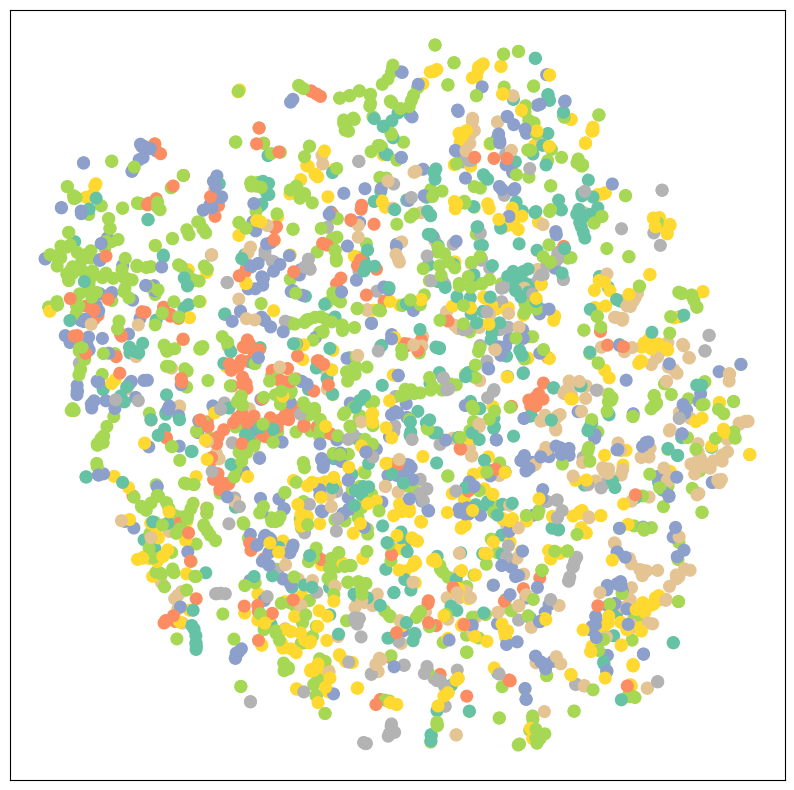

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualise(out, color=data.y)

# Trainning The Graph Neural Network

The Model will be trained on 100 Epochs *(A cycle of dataset was fed to the model)*
- Using Adam Optimisation
- Cross-Entropy Loss Function

In [ ]:
model = GCN(hidden_channels=16)
optimiser = torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

### Creating Training Function

The Train Function has
- Clear Gradient
- Performed a single forwarding pass
- Calculate the loss using trainning nodes
- Calculate Gradient and update the parameters

In [ ]:
def train():
    model.train()
    optimiser.zero_grad()
    out = model(data.x,data.edge_index)
    loss= criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimiser.step()
    return loss

### Creating Test Function

The Test Function
- Predicted Node class
- Extracted class label with the highest probability
- Checked how many values have been predicted correctly
- Creating Accuracy ratio using a sum of correct prediction divided by a total number of nodes

In [ ]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y [data.test_mask]
    test_acc = int(test_correct.sum())/int(data.test_mask.sum())
    return test_acc

### Training Loop

Training the model

In [ ]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


Model Evaluation

# Accuracy Test

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:4f}')

Test Accuracy: 0.815000


# Visualising The Trained Model

Visualising the model

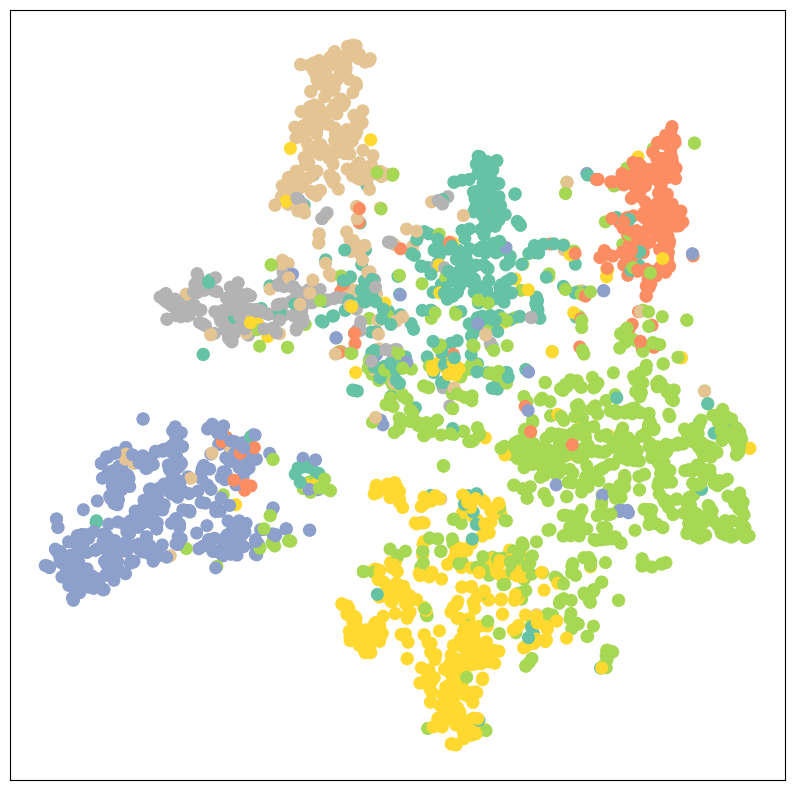

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualise(out, color=data.y)